Clone repositories we will be using and install the requirements.

In [ ]:
%tensorflow_version 1.x

!git clone https://github.com/NVIDIA/tacotron2
!sed -i 's/from distributed import/from tacotron2.distributed import/g' "/content/tacotron2/train.py"

!git clone https://github.com/r9y9/wavenet_vocoder
%cd /content/wavenet_vocoder
!git checkout 2092a64
!sed -i 's/from .version import __version__/ /g' "/content/wavenet_vocoder/wavenet_vocoder/__init__.py"

%cd /content

!pip install -q librosa unidecode nnmnkwii tensorboardX lws

TensorFlow 1.x selected.
Cloning into 'tacotron2'...
remote: Enumerating objects: 406, done.
remote: Total 406 (delta 0), reused 0 (delta 0), pack-reused 406
Receiving objects: 100% (406/406), 2.69 MiB | 2.39 MiB/s, done.
Resolving deltas: 100% (205/205), done.
Cloning into 'wavenet_vocoder'...
remote: Enumerating objects: 1400, done.
remote: Total 1400 (delta 0), reused 0 (delta 0), pack-reused 1400
Receiving objects: 100% (1400/1400), 20.20 MiB | 9.27 MiB/s, done.
Resolving deltas: 100% (714/714), done.
/content/wavenet_vocoder
Note: checking out '2092a64'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2092a64 Needs l

In [ ]:
import sys

sys.path.append('tacotron2/')

# Tacotron2 + WaveNet vocoder


/content


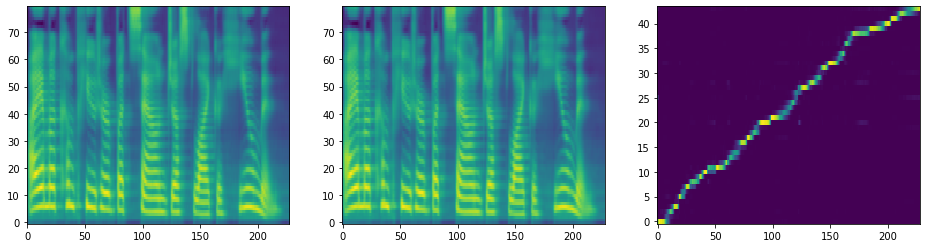

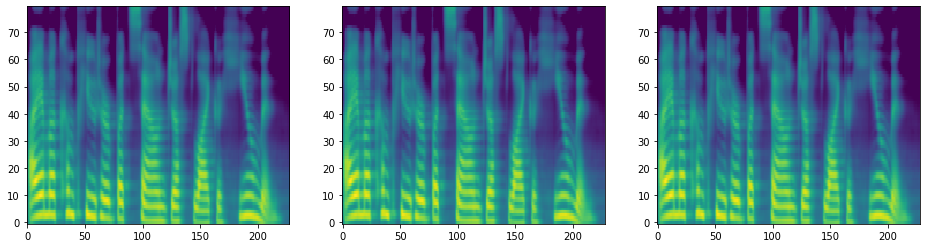

In [ ]:
%cd /content

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim, dynamic_range_decompression
from train import load_model
from text import text_to_sequence

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

# WaveNet parameters
min_level_db=-100
ref_level_db=20

def _amp_to_db(x):
    min_level = np.exp(min_level_db / 20 * np.log(10))
    return 20 * np.log10(np.maximum(min_level, x))

def _normalize(S):
    return np.clip((S - min_level_db) / -min_level_db, 0, 1)

hparams = create_hparams()
hparams.sampling_rate = 22050

checkpoint_path = "/content/drive/MyDrive/gt_pretrained_models/tacotron2_statedict.pt"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

text = "I am a computer but sound just like a human."
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

# Check https://github.com/NVIDIA/tacotron2/issues/24
# Expected range: 0 - 1

# Tacotron 2 Training Params
filter_length = 1024
hop_length = 256
win_length = 1024
sampling_rate = 22050
mel_fmin = 0
mel_fmax = 8000
taco_stft = TacotronSTFT(
    filter_length, hop_length, win_length, 
    sampling_rate=sampling_rate, mel_fmin=mel_fmin, 
    mel_fmax=mel_fmax)

# Project from Mel-Spectrogram to Spectrogram
mel_decompress = taco_stft.spectral_de_normalize(mel_outputs_postnet)
mel_decompress = mel_decompress.transpose(1, 2).data.cpu()
spec_from_mel_scaling = 1000
spec_from_mel = torch.mm(mel_decompress[0].float(), taco_stft.mel_basis)
spec_from_mel = spec_from_mel.transpose(0, 1)
spec_from_mel = spec_from_mel * spec_from_mel_scaling

# WaveNet Training Params
filter_length = 1024
hop_length = 256
win_length = 1024
sampling_rate = 22050
mel_fmin = 125
mel_fmax = 7600

taco_stft_other = TacotronSTFT(
    filter_length, hop_length, win_length, 
    sampling_rate=sampling_rate, mel_fmin=mel_fmin, mel_fmax=mel_fmax)

# Project from Spectrogram to r9y9's WaveNet Mel-Spectrogram
mel_minmax = taco_stft_other.spectral_normalize(
    torch.matmul(taco_stft_other.mel_basis, spec_from_mel))

mel_minmax = dynamic_range_decompression(mel_minmax)

melnp = mel_minmax.cpu().numpy().transpose()

melnp = _amp_to_db(melnp) - ref_level_db
melnp = _normalize(melnp)
melnp = (melnp - np.min(melnp)) / (np.max(melnp) - np.min(melnp))

melnpimg = np.array(melnp.transpose())
plot_data((melnpimg, melnpimg, melnpimg))

np.save('/content/mel.npy', melnp)

In [ ]:
%cd /content/wavenet_vocoder
!python /content/wavenet_vocoder/synthesis.py --conditional=/content/mel.npy \
    --preset=/content/drive/MyDrive/gt_pretrained_models/20180510_mixture_lj_checkpoint_step000320000_ema.json \
    /content/drive/MyDrive/gt_pretrained_models/20180510_mixture_lj_checkpoint_step000320000_ema.pth \
    /content/ \

from IPython.display import Audio
Audio("/content/20180510_mixture_lj_checkpoint_step000320000_ema.wav")

/content/wavenet_vocoder
Using TensorFlow backend.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Command line args:
 {'--conditional': '/content/mel.npy',
 '--file-name-suffix': '',
 '--help': False,
 '--hparams': '',
 '--initial-value': None,
 '--length': '32000',
 '--max-abs-value': '-1',
 '--output-html': False,
 '--preset': '/content/drive/MyDrive/gt_pretrained_models/20180510_mixture_lj_checkpoint_step000320000_ema.json',
 '--speaker-id': None,
 '--symmetric-mels': False,
 '<checkpoint>': '/content/drive/MyDrive/gt_pretrained_models/20180510_mixture_lj_checkpoint_step000320000_ema.pth',
 '<dst_dir>': '/content/'}
Load checkpoint from /content/drive/MyDrive/gt_pretraine